<a href="https://colab.research.google.com/github/hamedhelali/Fine-tuning-BERT-for-NLI/blob/master/NLI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning BERT for Natural Language Inference

#### Hamed Helali

## 1. Introduction
In this notebook, I will build a deep learning model to perform Natural Language Inference (NLI) task. NLI is classifying relationships between pairs of sentences to *contradication*, *entailment* or *neutral*. First, we will develop a preliminary model by fine-tuning a pretrained BERT. Then we will explore different models to tune hyperparameters and get better performance. As a more systematic approach (than mere trial and error), we will use random search to tune hyperparameters.  
Dataset used for this task is training, development and test sets from [Stanford Natural Language Inference (SNLI) Corpus](https://nlp.stanford.edu/projects/snli/). Training set of this data set has 550153 examples and dev and test sets each have 10000 examples. Each example have been labeled independently by 5 people and the best label is chosen as 'gold label'. For some examples there is no gold label and the this field equals to '-'.


In [1]:
from google.colab import drive
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
import IPython
random.seed(1366)

In the below cell I am going to make sure that TensorFlow can find a GPU device.

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Note that this notebook have been primarily developed on Google Colab. Data were uploaded to google drive. So, we mount google drive and import datasets from drive to google colab VM.

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
tr = pd.read_csv("/content/drive/My Drive/Stanford NLI/snli_1_train.csv")
dev = pd.read_csv("/content/drive/My Drive/Stanford NLI/snli_1_dev.csv")
ts = pd.read_csv("/content/drive/My Drive/Stanford NLI/snli_1_test.csv")

In [4]:
train_corpus = tr[['gold_label', 'sentence1', 'sentence2']]
dev_corpus = dev[['gold_label', 'sentence1', 'sentence2']]
test_corpus = ts[['gold_label', 'sentence1', 'sentence2']]
train_corpus.head()

,gold_label,sentence1,sentence2
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette."
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse."
3,neutral,Children smiling and waving at camera,They are smiling at their parents
4,entailment,Children smiling and waving at camera,There are children present


## 2. Exploring the Data
At this stage, we are going to take a look at 10 random examples of each of the contradication, entailment and neutral relationships to grasp a more concrete idea of what they mean.

In [6]:
def sentence_sampler(category, n=10):
  """
  Prints a sample of sentences with a certain label of relationship (category) from train set

  INPUTS:
    category (string): category of relationship
    n (int): sample size
  """
  sample = train_corpus[train_corpus.gold_label == category].sample(n)
  for index, row in sample.iterrows():
    print("Sentence1:")
    print(row['sentence1'])
    print("Sentence2:")
    print(row['sentence2'])
    print("\n")

In [7]:
print("EXAMPLES OF CONTRADICTION:")
print("\n")
sentence_sampler('contradiction')

print("EXAMPLES OF ENTAILMENT:")
print("\n")
sentence_sampler('entailment')

print("EXAMPLES OF NEUTRAL:")
print("\n")
sentence_sampler('neutral')

EXAMPLES OF CONTRADICTION:


Sentence1:
Two men, one wearing red uniform with white stripes and the other a white uniform are playing soccer.
Sentence2:
two teams of soccer players kick a baseball around a hockey rink.


Sentence1:
two people are standing in a large arch doorway.
Sentence2:
Two people are laying down.


Sentence1:
Slender dog running in the sand on a sunny day.
Sentence2:
A pet swimming in a pool.


Sentence1:
a girl speeds by on her scooter.
Sentence2:
The girl is trying to work.


Sentence1:
A man wearing latex gloves with a tool on his hand is operating on something.
Sentence2:
A man is welding.


Sentence1:
Two men work on a metal roof in the sunlight, one man is wearing a white shirt and the other man is wearing a black shirt and holding a drill.
Sentence2:
Two men are doing the plumbing.


Sentence1:
A woman in a headscarf sits near children in a box decorated with flowers and balloons.
Sentence2:
A group of children is unsupervised.


Sentence1:
A left handed Ma

As I mentioned in the introduction section, some examples do not have gold label. Among the other examples three classes are distributed in balance.

In [ ]:
train_corpus.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
-,785,785
contradiction,183187,183185
entailment,183416,183414
neutral,182764,182762


So, I drop examples with label '-' in all train, dev and test sets. 



In [8]:
train_corpus = train_corpus[train_corpus['gold_label'] != '-']
dev_corpus = dev_corpus[dev_corpus['gold_label'] != '-']
test_corpus = test_corpus[test_corpus['gold_label'] != '-']

In [ ]:
train_corpus.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,183187,183185
entailment,183416,183414
neutral,182764,182762


In [ ]:
dev_corpus.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,3278,3278
entailment,3329,3329
neutral,3235,3235


In [ ]:
test_corpus.groupby('gold_label').count()

,sentence1,sentence2
gold_label,,
contradiction,3237,3237
entailment,3368,3368
neutral,3219,3219


### 2.1 Dev and Test Set Distributions
Before building any models and iterating over them to improve performance,it is necessay to make sure that development and test data sets come from the same distribution. If it is not the case, all the fine-tuning and performance improvement effort will be in vain, because you have set your target (dev test) in the wrong (different) place. We do this investigation from two view points:
* Are the distributions of sentence lengths similar in both data sets?
* Are the vacabularies of the words used in both data sets similiar? After all, it will not be a good idea to tune a model to work well on fairy tails and then expect to have also good performance on Shakespeare's poems. (As an extreme example)

In [ ]:
## Comparing length of sentences in both datasets
# dev_set
dev_corpus["sen1_len"] = dev_corpus['sentence1'].apply(len)
dev_corpus["sen2_len"] = dev_corpus['sentence2'].apply(len)
dev_corpus['sen1 - sen2'] = dev_corpus["sen1_len"] - dev_corpus["sen2_len"]

# test_set
test_corpus["sen1_len"] = test_corpus['sentence1'].apply(len)
test_corpus["sen2_len"] = test_corpus['sentence2'].apply(len)
test_corpus['sen1 - sen2'] = test_corpus["sen1_len"] - test_corpus["sen2_len"]

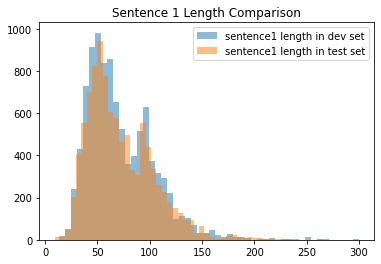

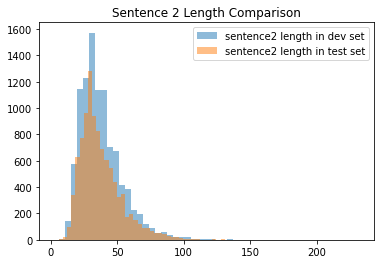

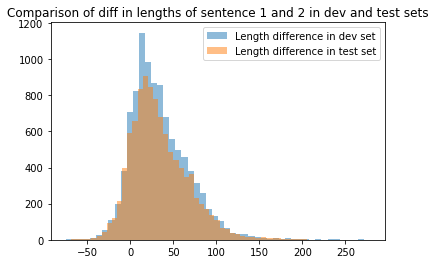

In [ ]:
plt.hist(dev_corpus['sen1_len'], bins=50, label="sentence1 length in dev set", alpha=0.5)
plt.hist(test_corpus['sen1_len'], bins=50, label="sentence1 length in test set", alpha=0.5)
plt.title("Sentence 1 Length Comparison")
plt.legend(loc='best')
plt.show()

plt.hist(dev_corpus['sen2_len'], bins=50, label="sentence2 length in dev set", alpha=0.5)
plt.hist(test_corpus['sen2_len'], bins=50, label="sentence2 length in test set", alpha=0.5)
plt.title("Sentence 2 Length Comparison")
plt.legend(loc='best')
plt.show()

plt.hist(dev_corpus['sen1 - sen2'], bins=50, label="Length difference in dev set", alpha=0.5)
plt.hist(test_corpus['sen1 - sen2'], bins=50, label="Length difference in test set", alpha=0.5)
plt.title("Comparison of diff in lengths of sentence 1 and 2 in dev and test sets")
plt.legend(loc='best')
plt.show()

It is evident that dev and test sets are similiar length-wise. Then, Let's go into the vocabulary used in each data set.

In [11]:
def unique_words_seperator(column):
  """
  Returns a list consisting of all the unique words in a column of a dataframe. splitor of is considered to be ' '
  (space character) and punctuation marks are deleted from the end of each word 
  
  INPUT:
    column (pandas.Series object): a series object which has string values

  OUTPUT:
    python list: list of unique words used in the input pandas series 
  """

  words_list = list(column.str.split(' ', expand=True).stack().unique())
  # In the following line, I am removing puncuation mark from the end or beginning of the words.
  rec_words_list = [w.strip('.,;()[]') for w in words_list]
  return rec_words_list

In [12]:
def common_words_finder(vocab1, vocab2):
  """
  Finds common words between two lists of words

  INPUTS:
    vocab1 (python list): first list of words
    vocab2 (python list): second list of words
  
  OUTPUTS:
    python list: intersection of the words between two input lists
  """

  common_vocab = [word for word in vocab1 if word in vocab2] 
  return common_vocab

In [ ]:
dev_s1 = unique_words_seperator(dev_corpus['sentence1'])
dev_s2 = unique_words_seperator(dev_corpus['sentence2'])
dev_vocab = dev_s1 + dev_s2
dev_vocab = list(set(dev_vocab))    # to only keep unique words

test_s1 = unique_words_seperator(test_corpus['sentence1'])
test_s2 = unique_words_seperator(test_corpus['sentence2'])
test_vocab = test_s1 + test_s2
test_vocab = list(set(test_vocab))    # to only keep unique words

print("Number of unique words in dev set: ", str(len(dev_vocab)))
print("Number of unique words in test set: ", str(len(test_vocab)))
print("Number of unique common words in dev and test set: ", str(len(common_words_finder(dev_vocab, test_vocab))))
print("percentage of common words in test set: ", str(len(common_words_finder(dev_vocab, test_vocab)) / len(test_vocab)))

Number of unique words in dev set:  6987
Number of unique words in test set:  7159
Number of unique common words in dev and test set:  4096
percentage of common words in test set:  0.5721469478977511


We can see that less than 60% of words used in test set are common with test set. In this sense they can be considered to have relatively different distributions due to use of different vocabulary of words. To fix this issue two solutions can be considered:
* Shuffling the test and dev sets and randomly splitting it into two equal halves.
* Randomly splitting the test set into to equal halves and using one half as dev set and the other as test set.

Assuming that the current test set is a good representative of the data that model will predict in practice, the first solution is not the best idea. The reason is that it distorts representativeness of test data. In this case, we may show a great performance in testing our model but may not perform properly in practice (or vice verse). Therefore, since current test is already large enough, I take the second solution.

In [9]:
mask = np.random.rand(len(test_corpus)) < 0.5
dev_corpus2 = test_corpus[mask]
test_corpus2 = test_corpus[~mask]
print(len(dev_corpus2))
print(len(test_corpus2))

4818
5006


Let's check percentage of common words for the new dev and test sets:

In [13]:
dev2_s1 = unique_words_seperator(dev_corpus2['sentence1'])
dev2_s2 = unique_words_seperator(dev_corpus2['sentence2'])
dev_vocab2 = dev2_s1 + dev2_s2
dev_vocab2 = list(set(dev_vocab2))    # to only keep unique words

test2_s1 = unique_words_seperator(test_corpus2['sentence1'])
test2_s2 = unique_words_seperator(test_corpus2['sentence2'])
test_vocab2 = test2_s1 + test2_s2
test_vocab2 = list(set(test_vocab2))    # to only keep unique words
print("percentage of common words in test set: ", str(len(common_words_finder(dev_vocab2, test_vocab2)) / len(test_vocab2)))

percentage of common words in test set:  0.7592528536838464


Now they have 76% of vocabulary in common.

## 3. Building the model
We will use pretrained uncased english BERT with L=12 transformer blocks, A=12 attention heads and H=768 hidden size (i.e. each input word will be encoded into a 768 elements vector which has meaning and context of the word) as the core encoder (word embedder) of our model architecture. In the preliminary model, classifier head will be connected to the BERT encoder with some default values for hyperparameters. Then, we will search for tuning the hyperparameters.  
The aforementioned BERT encoder can be imported form TensorFlow hub (see [here](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2)). Also all modules and libraries needed to BERT encoding is availabe by installing and importing [official](https://github.com/tensorflow/models/tree/master/official) package which has official models of TensorFlow.  
### 3.1 Preprocess step: Preparing inputs of the BERT encoder
BERT encoder expects three lists as inputs for each sentence:
* **input word ids:** Each word of a sentence is tokenized using a wordpiece vocabulary then the tokens are transformed to their ids in the vacabulary and a list of ids is inputted to BERT. This is a 2D tensor of shape `[Number of examples, max_seq_length]`. *Note that* BERT expects each example to begin with a `'[CLS]'` token and sentences be seperated with a `'[SEP]'` token.
* **Input Mask:** This is a 2D tensor of 1 or 0 with with the same shape as `input_word_ids` which allows the model to differentiate between real words and padding. It is 1 wherever input is a real word and 0 wherever input is padding. This padding happens because the `input_word_ids` are defined as ragged tensors at first and then are casted `.to_tensor()`.
* **Input segment ids:** This is a 2D tensor of 1 or 0 with with the same shape as `input_word_ids` which allows the model to know which words relate to the first sentence and which words relate to the second sentence.

In [ ]:
!pip install tf-models-official

In [11]:
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import bert
import official.nlp.bert.tokenization

import os

Here we define a BERT tokenizer instance that uses wordpiece vocabulary with 30000 entries.

In [12]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tokenizer = bert.tokenization.FullTokenizer(vocab_file=os.path.join(gs_folder_bert, "vocab.txt"),
     do_lower_case=True)

In [13]:
def sentence_encoder(s, tokenizer):
  """
  This turns each sentence into a list of tokens, adds '[SEP]' token to end of the list, then turns tokens
  into ids and returns list of ids.

  INPUTS:
    s: input sentence
    tokenizer: an instance of BERT tokenizer
  
  OUTPUTS:
    (python list): list of ids of the words of input sentence 
  """
  
  tokens = list(tokenizer.tokenize(str(s)))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

In [14]:
def bert_input_encoder(train_corpus, tokenizer):
  """
  gets a dataframe of input sentences and returns required inputs of BERT encoder in a dictionary

  INPUTS:
    train_corpus (pandas.Dataframe): data frame of input sentences
    tokenizer: an instance of BERT tokenizer
  
  OUTPUTS:
    (python dictionary): A dictionary with 3 keys which has required inputs of BERT encoder
  """

  sentence1 = tf.ragged.constant([sentence_encoder(s, tokenizer) for s in np.array(train_corpus['sentence1'])])
  sentence2 = tf.ragged.constant([sentence_encoder(s, tokenizer) for s in np.array(train_corpus['sentence2'])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
  
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  segment_cls = tf.zeros_like(cls)
  segment_s1 = tf.zeros_like(sentence1)
  segment_s2 = tf.ones_like(sentence2)
  input_segment_ids = tf.concat([segment_cls, segment_s1, segment_s2], axis=-1).to_tensor()

  inputs_dic = {
    'input_word_ids': input_word_ids.to_tensor(),
    'input_mask': input_mask,
    'input_segment_ids': input_segment_ids
  }

  return inputs_dic

### 3.2 Architecture of the First Model
In the cell below we define a model builder function which connects a classifier softmax layer to `'[CLS]'` output of BERT encoder.

In [15]:
def inference_model_builder():
  """
  Builds and returns a model instance of Keras with the functional API
  """
  max_seq_length = 125

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_segment_ids")

  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

  pooled_output, _ = bert_layer([input_word_ids, input_mask, input_segment_ids])
  # pooled output is the embedding output for the '[CLS]' token that is dependant on all words of two sentences
  # and can be used for classfication purposes

  output_class = tf.keras.layers.Dense(units=3, activation='softmax')(pooled_output)
  
  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_segment_ids], outputs=output_class)

  optimizer = tf.keras.optimizers.Adam(lr=1e-5)
  model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [15]:
model = inference_model_builder()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 125)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 125)]        0                                            
__________________________________________________________________________________________________
input_segment_ids (InputLayer)  [(None, 125)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

We can see the model structure graphically below:

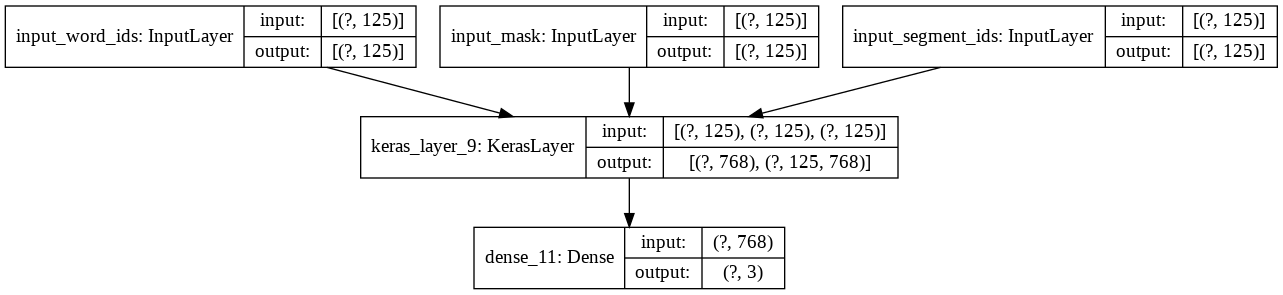

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 3.3 First Training of the Model
As the first round, we train the model using entire training dataset including all about 550000 examples. We choose the batch size of 64 for this training.  
In the cell below, we are preparing (encoding) training set as well as dev and 
test sets to feed as input to BERT model"

In [32]:
model_input = bert_input_encoder(train_corpus, tokenizer)
dev_input = bert_input_encoder(dev_corpus2, tokenizer)
test_input = bert_input_encoder(test_corpus2, tokenizer)

We also need to turn the `str` labels of examples into `int` to be able to use in the model.

In [9]:
le = LabelEncoder()  # from sklearn.preprocessing import LabelEncoder
train_corpus['int_label'] = le.fit_transform(train_corpus['gold_label'])
dev_corpus2['int_label'] = le.transform(dev_corpus2['gold_label'])
test_corpus2['int_label'] = le.transform(test_corpus2['gold_label'])
train_corpus.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,gold_label,sentence1,sentence2,int_label
0,neutral,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,2
1,contradiction,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",0
2,entailment,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",1
3,neutral,Children smiling and waving at camera,They are smiling at their parents,2
4,entailment,Children smiling and waving at camera,There are children present,1


Here we fit the model and save the trained model in a file named 'first_training.h5'

In [17]:
logger = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/NLI_training/logs/first_model')

In [ ]:
model.fit(model_input, train_corpus.int_label.values,
          epochs=2,
          batch_size=64,
          verbose=1,
          callbacks=[logger])

In [22]:
model.save("/content/drive/My Drive/NLI_training/first_training.h5")

In [19]:
model = tf.keras.models.load_model("/content/drive/My Drive/NLI_training/first_training.h5",
                                   custom_objects={'KerasLayer':hub.KerasLayer})

Note that these saves and loads of model that you saw (and will see) is because of Google colob's disconnecting and restarting the VM.

### 3.4 Performance of the first model.

Due to the resluts of model fitting, training set accuracy of the first model is 89%.

In [30]:
def accuracy(model, bert_input, corpus):
  """
  Gets input sentences (in BERT's required format), sentences corpus and a model and prints
  accuracy rate of the model predicting labels of the corpus.

  INPUTS:
    model (tf.keras.model.Model): input model that we want to measure it accuraucy
    bert_input (python dictionary): input sentences in BERT's required format
    corpus (pandas.Dataframe): A data frame of input corpus
  """
  predictions =[np.argmax(i) for i in model.predict(bert_input)]
  acc = np.mean(predictions == corpus.int_label.values)
  print(acc)

Dev set accuracy of the first model is as follows:

In [22]:
accuracy(model, dev_input, dev_corpus2)

0.8986731001206273

As we can see there is not a considerable difference between train and dev set accuracy. Therefore our model does not have variance problem. Bias can be a potential problem if human error rate is much less than 10%. This needs to be investigated in a separate study.  

And test set accuracy of model is:

In [26]:
accuracy(model, test_input, test_corpus2)

0.8971134020618556

### 3.5 Training With A Smaller Data Set

Since our training dataset is too large and the available computational capacity is limited, iterating model fitting with this data set and tuning hyperparameters will be very time consuming. Therefore, we are going to train model with the same architecute but a smaller training dataset. To this purpose, 0.1 of the examples are sampled randomly. So, size of the new train set will be about 55000 examples.



In [26]:
mask = np.random.rand(len(train_corpus)) < 0.1
new_train_corpus = train_corpus[mask]

new_model_input = bert_input_encoder(new_train_corpus, tokenizer)

In [ ]:
model_s_b64 = inference_model_builder()

In [ ]:
logger_s_b64 = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/NLI_training/logs/model_s_b64')

In [19]:
model_s_b64.fit(new_model_input, new_train_corpus.int_label.values,
          epochs=2,
          batch_size=64,
          verbose=1,
          callbacks=[logger_s_b64])

Epoch 1/2


  1/859 [..............................] - ETA: 8:01 - loss: 1.4580 - accuracy: 0.3438WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


  2/859 [..............................] - ETA: 18:40 - loss: 1.5451 - accuracy: 0.3125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.8021s vs `on_train_batch_end` time: 1.2489s). Check your callbacks.


859/859 [==============================] - 1171s 1s/step - loss: 0.6216 - accuracy: 0.7378
Epoch 2/2
859/859 [==============================] - 1170s 1s/step - loss: 0.4279 - accuracy: 0.8358


As you can see in the results of model fitting, the training set accuracy of the model is 83.5%.

In [20]:
model_s_b64.save("/content/drive/My Drive/NLI_training/model-s-b64.h5")

In [26]:
model_s_b64 = tf.keras.models.load_model("/content/drive/My Drive/NLI_training/model-s-b64.h5",
                                   custom_objects={'KerasLayer':hub.KerasLayer})

Dev set accuracy of the new model trained with smaller data set is 85.2%:

In [27]:
accuracy(model_s_b64, dev_input, dev_corpus2)

  2/154 [..............................] - ETA: 27sWARNING:tensorflow:Callbacks method `on_predict_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_predict_batch_end` time: 0.2930s). Check your callbacks.


154/154 [==============================] - 48s 310ms/step
0.8528632565722437


### 3.6 Training With a Smaller Batch Size
In the remainder, we want to check how the performance will change if we choose the batch size to be 16 instead of 64. Again, I will use the smaller data set.

In [32]:
model_s_b16 = inference_model_builder()
logger_s_b16 = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/NLI_training/logs/model_s_b16')

model_s_b16.fit(new_model_input, new_train_corpus.int_label.values,
          epochs=2,
          batch_size=16,
          verbose=1,
          callbacks=[logger_s_b16])

Epoch 1/2


   1/3403 [..............................] - ETA: 20:51 - loss: 1.5016 - accuracy: 0.4375WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


   2/3403 [..............................] - ETA: 49:14 - loss: 1.5090 - accuracy: 0.4688WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4272s vs `on_train_batch_end` time: 0.9418s). Check your callbacks.


3403/3403 [==============================] - 2667s 784ms/step - loss: 0.5544 - accuracy: 0.7758
Epoch 2/2
3403/3403 [==============================] - 2666s 783ms/step - loss: 0.3621 - accuracy: 0.8659


As you can see train set accuracy with batch_size = 16 is 86.6% ; a little bit higher than training with batch_size = 64.

In [33]:
model_s_b16.save("/content/drive/My Drive/NLI_training/model-s-b16.h5")

In [34]:
model_s_b16 = tf.keras.models.load_model("/content/drive/My Drive/NLI_training/model-s-b16.h5",
                                   custom_objects={'KerasLayer':hub.KerasLayer})

In [37]:
accuracy(model_s_b16, dev_input, dev_corpus2)

0.8593845526798451


Dev test accuracy does not have considerable difference with the previous training.

## 4. Hyperparameters tuning
What we did in the last section in testing performance of model with different batch sizes, was and example of tuning hyperparameters. However, batch size is not the only hyperparameter of the training process. To perform the inference task we chose the model architecture and some variables of the learning algorithm (e.g. learning rate) without any special reason. These variables are also hyperparameters (i.e. parameters that govern model architecture and learning algorithm performance) and need to be optimized to get the best possible model. Hyperparameter that we will search to optimize for this problem are:  
* **Feedforward layers on top of the bert encoder:** In last part, we directly connected the `'[CLS]'` output of the bert encoder to a softmax layer. It is not necessarily the best possible option. we will investigate to see if adding some (up to 3) dense layers before the softmax layer improves the performance.
* **No. of units in each layer:** Number of units in the each of layers of feedforward is another hyperparameter that we will investigate. I will not tune the activation functions, though.
* **Dropout regularization on each layer and their rates:** The other question is if we need to do dropout regularization on the outputs of layers. If yes, what is the best rate of dropout?
* **Learning rate of Adam optimization algorithm:** Learning rate of (any) optimization alogrithm is the most important hyperparameter to be tuned. We will set an interval of $10^{-6}$ to $10^{-4}$ and sample it in a logarithmic scale. This interval is inspired by the learning rates that authors of the BERT paper have chosen for different tasks of fine tuning.  
We will not tune on the $\beta_1=0.9$ and $\beta_2=0.999$ and $\epsilon=10^{-7}$ parameters of Adam optimization algorithm and will use the default valuse.

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

The function below, defines a hyper model. Hyper model is like the previous functional Keras model, except that hyperparameters are specified to be tuned by `hp` instance. 

In [16]:
def hyper_model_builder(hp):
  """
  Builds and returns a hypermodel instance that Keras tuner does search on it

  INPUTS:
    hp: hyperparameter instance of Keras tuner
  """
  
  max_seq_length = 125
  flag = 0 # this flag shows if the for loop have been activated or not.

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_segment_ids")

  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

  pooled_output, _ = bert_layer([input_word_ids, input_mask, input_segment_ids])
  # pooled output is the embedding output for the '[CLS]' token that is dependant on all words of two sentences
  # and can be used for classfication purposes

  for i in range(hp.Int('number of added head layers', min_value=0, max_value=3)):
    flag += 1
    if i == 0:
      X = tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                                activation='relu') (pooled_output)
    else:
      X = tf.keras.layers.Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                                activation='relu')(X)
    X = tf.keras.layers.Dropout(hp.Float('dropout_' + str(i), min_value=0, max_value=0.5, step=0.1))(X)
  
  if flag > 0:
    output_class = tf.keras.layers.Dense(units=3, activation='softmax')(X)
  else:
    output_class = tf.keras.layers.Dense(units=3, activation='softmax')(pooled_output)
  
  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_segment_ids], outputs=output_class)

  hp_learning_rate = hp.Float('learning_rate', min_value = 1e-6, max_value = 1e-4, sampling='log')
  optimizer = tf.keras.optimizers.Adam(lr=hp_learning_rate)
  model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

Random search method will be used to exploaring the hyperparameter space. Thus, we define `tuner` as an instance of random search tuner. Considering limited computational capacity and to avoid long periods of computation, I will do the search on ralatively small sample (10 points) from hyperparameters space.

In [27]:
tuner = kt.RandomSearch(hyper_model_builder,
                        objective='val_accuracy', 
                        max_trials=10,
                        executions_per_trial=3,
                        directory = '/content/drive/My Drive/NLI_training',
                        project_name = 'NLI_hp_tuning')                     

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/NLI_training/NLI_hp_tuning/oracle.json


INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/NLI_training/NLI_hp_tuning/oracle.json


INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/NLI_training/NLI_hp_tuning/tuner0.json


INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/NLI_training/NLI_hp_tuning/tuner0.json


In [28]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [29]:
tuner.search(new_model_input, new_train_corpus.int_label.values,
             validation_data=(dev_input, dev_corpus2.int_label.values),
             callbacks = [ClearTrainingOutput()],
             verbose=1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In the block above, you can see the result of random search for tuning values of hyperparameters. Basically, to build a model with the best hyperparameters found, we should use the following line of code:
```
best_model = tuner.hypermodel.build(best_hps)
```
We are not doing this here because as I mentioned before, this notebook is executed on Google colab and its disconnection totally restarts VM. Therefore to avoid repeating the search, I will manually build the tuned model.

In [20]:
def tuned_model_builder():
  max_seq_length = 125

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_segment_ids")

  bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2", trainable=True)

  pooled_output, _ = bert_layer([input_word_ids, input_mask, input_segment_ids])
  # pooled output is the embedding output for the '[CLS]' token that is dependant on all words of two sentences
  # and can be used for classfication purposes

  X = tf.keras.layers.Dense(units=64, activation='relu')(pooled_output)
  X = tf.keras.layers.Dropout(0.2)(X)
  
  X = tf.keras.layers.Dense(units=64, activation='relu')(X)
  X = tf.keras.layers.Dropout(0.3)(X)

  X = tf.keras.layers.Dense(units=96, activation='relu')(X)
  X = tf.keras.layers.Dropout(0.2)(X)
  
  output_class = tf.keras.layers.Dense(units=3, activation='softmax')(X)
  
  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_segment_ids], outputs=output_class)

  hp_learning_rate = 2.76867473400574e-06
  optimizer = tf.keras.optimizers.Adam(lr=hp_learning_rate)
  model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [21]:
tuned_model = tuned_model_builder()
tuned_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 125)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 125)]        0                                            
__________________________________________________________________________________________________
input_segment_ids (InputLayer)  [(None, 125)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

The architecture of new tuned model is as follows:

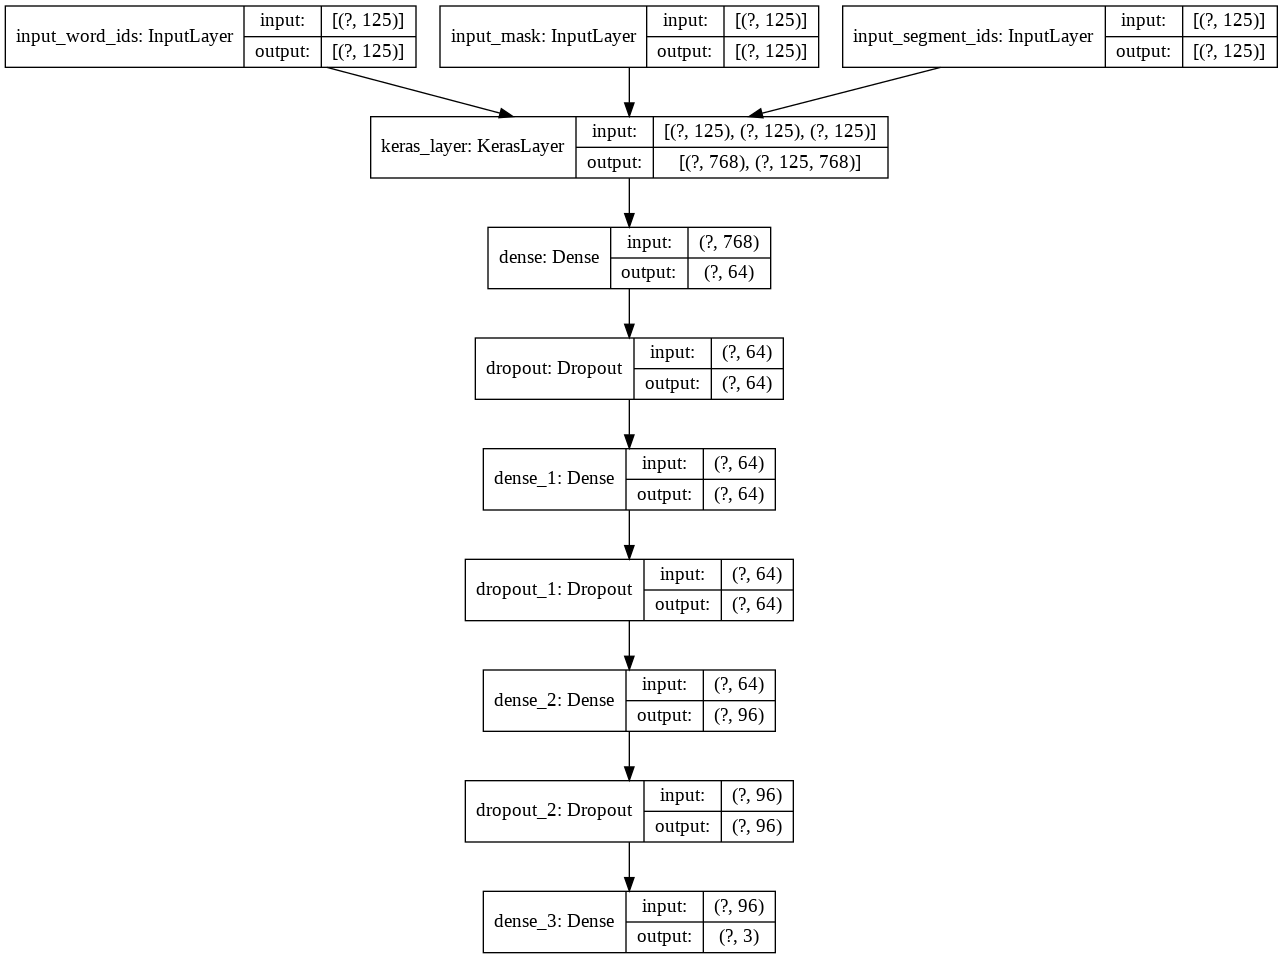

In [22]:
tf.keras.utils.plot_model(tuned_model, show_shapes=True)

And the learning rate is:

In [23]:
tf.keras.backend.eval(tuned_model.optimizer.lr)

2.7686747e-06

In [24]:
logger_tuned = tf.keras.callbacks.TensorBoard(log_dir='/content/drive/My Drive/NLI_training/logs/new_tuned_model')

Note that since our new learning rate in about 0.2 times and learning will be slower, we train the new model for 5 epochs.

In [28]:
tuned_model.fit(new_model_input, new_train_corpus.int_label.values,
                batch_size=16,
                epochs=5,
                verbose=1,
                callbacks=[logger_tuned])

Epoch 1/5
   2/3416 [..............................] - ETA: 34:55 - loss: 0.6977 - accuracy: 0.7812WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3207s vs `on_train_batch_end` time: 0.6543s). Check your callbacks.


3416/3416 [==============================] - 1937s 567ms/step - loss: 0.5666 - accuracy: 0.7998
Epoch 2/5
3416/3416 [==============================] - 1936s 567ms/step - loss: 0.4902 - accuracy: 0.8306
Epoch 3/5
3416/3416 [==============================] - 1940s 568ms/step - loss: 0.4384 - accuracy: 0.8529
Epoch 4/5
3416/3416 [==============================] - 1942s 568ms/step - loss: 0.3872 - accuracy: 0.8729
Epoch 5/5
3416/3416 [==============================] - 1942s 568ms/step - loss: 0.3475 - accuracy: 0.8876


In [29]:
tuned_model.save("/content/drive/My Drive/NLI_training/tuned_model.h5")

Train set accuracy for the tuned model is 88.8% which is very close to (not-tuned) model trained with full training set.

In [33]:
accuracy(tuned_model, dev_input, dev_corpus2)

0.8620263591433278


Dev set accuracy for the tuned model is 86.2%. A slight improvement has been made in comparison to pervious models.

In [34]:
accuracy(tuned_model, test_input, test_corpus2)

0.8609098228663447


## 5. Conclusion

In the table below, we can see the performance summary of different models we explored in this notebook.

|    Model Name  |   Training set size  |   Batch size  |   Architecture and HPs  |   Training set accuracy  |   Development set accuracy  |
|:--------------:|:--------------------:|:-------------:|:-----------------------:|:------------------------:|:---------------------------:|
|   First model  |   Full (550000 ex.)  |       64      |           Basic         |            89%           |             89.7%           |
|   model_s_b64  |   Small (55000 ex.)  |       64      |           Basic         |           83.5%          |             85.3%           |
|   model_s_b16  |   Small (55000 ex.)  |       16      |           Basic         |           86.6%          |             85.9%           |
|   tuned_model  |   Small (55000 ex.)  |       16      |           Tuned         |           88.8%          |             86.2%           |

And the best test set accuracies we obtained are:

|    Model Name  |   Training set size  |   Test set accuracy  |
|:--------------:|:--------------------:|:--------------------:|
|   First model  |   Full (550000 ex.)  |         89.7%        |
|   tuned_model  |   Small (55000 ex.)  |         86.1%        |

As a wrap up, some points are worth discussing:
* Genarally it is observed that performance of models do not vary dramatically among training, dev and test sets and as far as this corpus is considered, variance and generalization is not an issue for our models.
* Even when training set is cut to one tenth, models' performances are not deteriorated significantly. All these show that our examples within and between data sets are mostly homogeneous.
* Random search for hyperparameter tuning has ended in a model that peforms better but not in a dramatic way. I can imagine two reasons for this:
  * First, We did a very limited search in the hyperparameter space and if we search a larger sample we may obtain slightly better performances.
  * Second and more important: It seems that BERT encoder, which is a large network with 110 million parameters, has a great anchor in our model and its impact is very much larger than the classification head we did hyperparameter tuning on. 

## 5. References
* BERT Paper: Jacob Devlin, Ming-Wei Chang, Kenton Lee, Kristina Toutanova: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", 2018.